# Results Analysis

In [12]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import time
from datetime import timedelta

### Load dataset

In [13]:
# read from csv
input_file_name = "results_id12041992.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)
test =  pd.read_csv(input_file_path, index_col=[0,1])

print test.loc[20].shape[0]
test.loc[20].tail()

27856


,true,last value,previous day,previous week,offline,batch
values,,,,,,
2015-02-01 02:45:00,88.6,45.8,97.5,77.7,86.212779,81.692954
2015-02-01 03:00:00,65.4,66.8,96.7,104.7,101.380768,88.459293
2015-02-01 03:15:00,65.7,76.3,92.2,57.4,65.364685,64.103531
2015-02-01 03:30:00,62.9,57.8,91.6,53.8,62.554910,60.638776
2015-02-01 03:45:00,52.3,47.1,105.2,40.3,58.840068,59.392707


In [14]:
# read from csv
input_file_name = "id12041992_20_AR_WF_DT.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data", "online results", "RF100-5"), input_file_name)
a =  pd.read_csv(input_file_path, sep=';')

a.shape

(105135, 2)

The problem is that we have different sizes of datasets. Online reuslts are larger, becasue it starts to validate at the first record, while offline and batch are only evaluating the last 20%.

In [15]:
a.tail()

,target,prediction
105130,88.6,81.283938
105131,65.4,78.953219
105132,65.7,75.935878
105133,62.9,74.286629
105134,52.3,73.595491


But the tail should be the same. Checking if target is actually the same.

We should take the last chunk of the online data, the same size as offline and batch.

In [16]:
testing_set_point = test.loc[20].shape[0]
main_subset = test.loc[20]
subset = a[-testing_set_point:]

The sizes are now the same.

In [17]:
print test.loc[20].shape
print main_subset.shape
print subset.shape

(27856, 6)
(27856, 6)
(27856, 2)


The problem is that they still have different indexes.

In [18]:
main_subset.tail()

,true,last value,previous day,previous week,offline,batch
values,,,,,,
2015-02-01 02:45:00,88.6,45.8,97.5,77.7,86.212779,81.692954
2015-02-01 03:00:00,65.4,66.8,96.7,104.7,101.380768,88.459293
2015-02-01 03:15:00,65.7,76.3,92.2,57.4,65.364685,64.103531
2015-02-01 03:30:00,62.9,57.8,91.6,53.8,62.554910,60.638776
2015-02-01 03:45:00,52.3,47.1,105.2,40.3,58.840068,59.392707


In [19]:
subset.tail()

,target,prediction
105130,88.6,81.283938
105131,65.4,78.953219
105132,65.7,75.935878
105133,62.9,74.286629
105134,52.3,73.595491


We will just override index from the main dataframe, to the online subset dataframe.

In [20]:
subset.index = main_subset.index
subset.tail()

,target,prediction
values,,
2015-02-01 02:45:00,88.6,81.283938
2015-02-01 03:00:00,65.4,78.953219
2015-02-01 03:15:00,65.7,75.935878
2015-02-01 03:30:00,62.9,74.286629
2015-02-01 03:45:00,52.3,73.595491


Now we can marge.

In [21]:
#pd.concat([main_subset, subset], axis=1) # to check if target and true are the same (they are)
main_subset['online'] = subset['prediction']
main_subset.tail()

,true,last value,previous day,previous week,offline,batch,online
values,,,,,,,
2015-02-01 02:45:00,88.6,45.8,97.5,77.7,86.212779,81.692954,81.283938
2015-02-01 03:00:00,65.4,66.8,96.7,104.7,101.380768,88.459293,78.953219
2015-02-01 03:15:00,65.7,76.3,92.2,57.4,65.364685,64.103531,75.935878
2015-02-01 03:30:00,62.9,57.8,91.6,53.8,62.554910,60.638776,74.286629
2015-02-01 03:45:00,52.3,47.1,105.2,40.3,58.840068,59.392707,73.595491


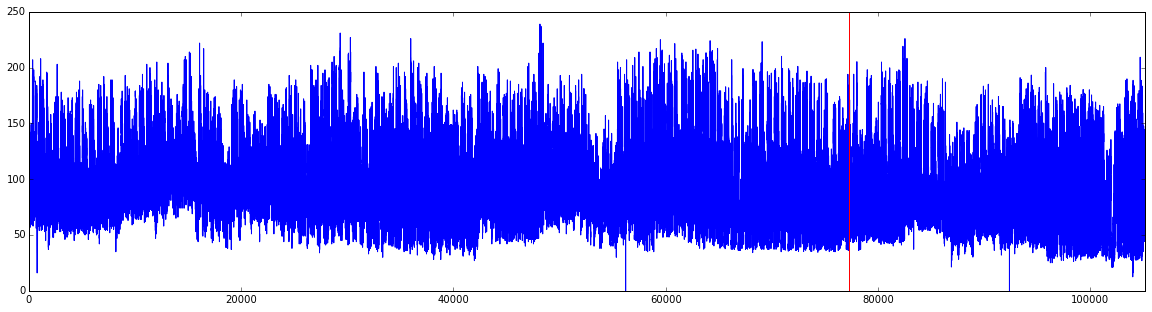

In [22]:
f = a['target'].plot(figsize=(20,5))
f.axvline(len(a)-testing_set_point, color='r')

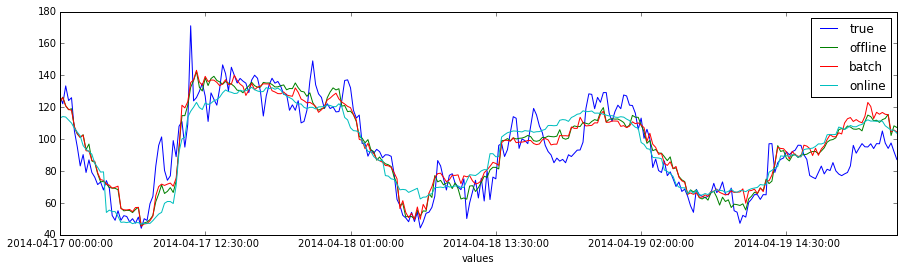

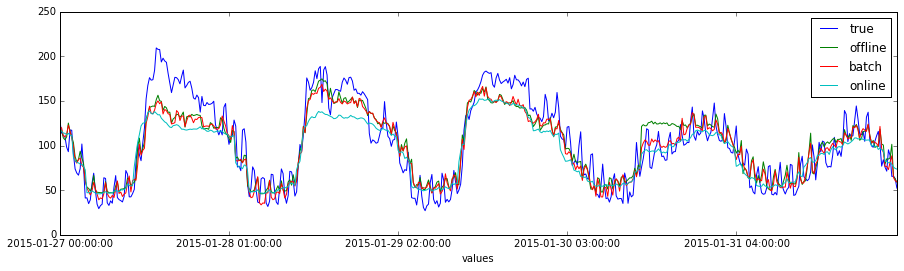

In [23]:
main_subset['2014-04-17 00:00:00':'2014-04-20 00:00:00'][['true','offline','batch', 'online']].plot(figsize=(15,4))
main_subset['2015-01-27 00:00:00':'2015-02-01 23:59:00'][['true','offline','batch', 'online']].plot(figsize=(15,4))

In [34]:
from sklearn.metrics import r2_score

def r2( g ):
    r2_lv = r2_score( g['true'], g['last value'] )
    r2_pd = r2_score( g['true'], g['previous day'] )
    r2_pw = r2_score( g['true'], g['previous week'] )
    r2_offline = r2_score( g['true'], g['offline'] )
    r2_batch = r2_score( g['true'], g['batch'] )
    r2_online = r2_score( g['true'], g['online'] )
    return pd.Series( dict(  r2_lv=r2_lv, r2_pd=r2_pd, r2_pw=r2_pw, r2_offline=r2_offline, r2_batch=r2_batch, r2_online=r2_online ) )

#subset = test['2014-04-17 00:00:00':'2014-04-27 00:00:00']
#subset = test.loc[20]['2015-01-05 00:00:00':'2015-02-01 23:59:00']
#subset = test['2014-04-17 00:00:00':'2015-02-01 23:59:00']
a=main_subset.groupby(main_subset.index.to_datetime().dayofyear, sort=False).apply(r2)
a

C:\Python27\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)


,r2_batch,r2_lv,r2_offline,r2_online,r2_pd,r2_pw
107,0.859974,-0.686172,0.846075,0.807209,0.772724,0.643299
108,0.804211,-3.238915,0.820229,0.673644,-0.756784,0.824633
109,0.433494,-2.020619,0.541461,0.532083,0.212182,-0.424814
110,0.516272,0.100122,0.622853,0.576121,0.115583,0.152906
111,0.481387,0.199518,0.528002,0.603172,0.130503,0.652303
112,0.884929,-0.812897,0.870139,0.778938,0.779473,0.460079
113,0.883512,-0.412710,0.861338,0.804178,0.846049,0.747058
114,0.758131,-0.271101,0.736273,0.636583,0.716188,0.657921
115,0.546447,-5.355815,0.513786,0.686184,-2.695457,0.671430
116,0.791743,-0.169815,0.790376,0.698492,0.697523,0.710453


Bar plot for last month. Major improvement for batch and online is not visible.

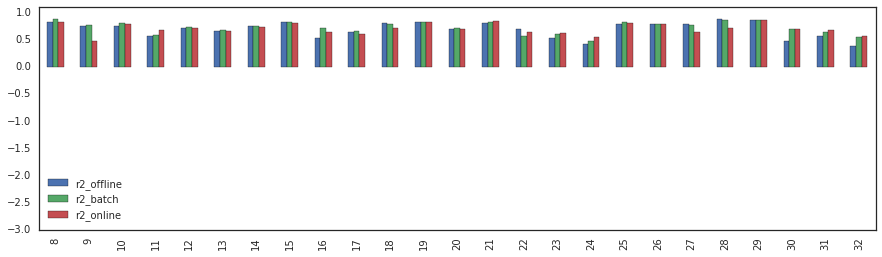

In [35]:
a[['r2_offline','r2_batch', 'r2_online']].tail(25).plot( kind='bar', figsize=(15,4), ylim=(-3, 1.1))

This can also be seen from the distribution plot

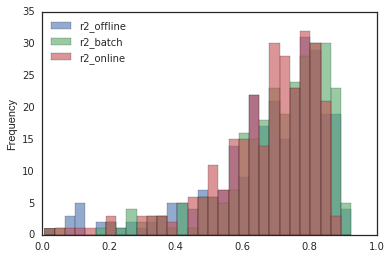

In [36]:
#subset = test.loc[20]['2014-04-17 00:00:00':'2015-02-01 23:59:00']
#main_subset['2014-04-17 00:00:00':'2015-02-01 23:59:00']
#a=subset.groupby(subset.index.to_datetime().dayofyear, sort=False).apply(r2)

b = a[['r2_offline','r2_batch', 'r2_online']]
#a[['r2_offline','r2_batch']].plot( kind='hist', figsize=(15,4))
#a[['r2_offline','r2_batch']].hist(figsize=(15,4), bins=20)
#a[['r2_offline','r2_batch']].plot.hist(bins=30)
b[b > 0].plot.hist(bins=30, alpha=0.6)

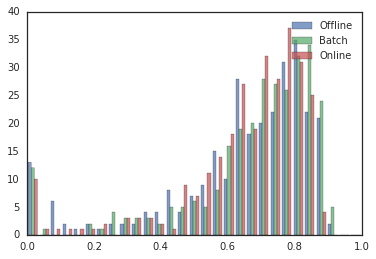

In [37]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

b = a[['r2_offline','r2_batch', 'r2_online']]

c = b[b > 0].reset_index()[['r2_offline','r2_batch', 'r2_online']]

c = c.fillna(0)

x = c["r2_offline"].values
y = c["r2_batch"].values
z = c["r2_online"].values
data = np.vstack([x, y, z]).T
bins = np.linspace(0, 1, 30)

plt.hist(data, bins, alpha=0.7, label=['Offline', 'Batch', 'Online'])
plt.legend(loc='upper right')
plt.show()

R2 scatter plot

C:\Python27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  if __name__ == '__main__':


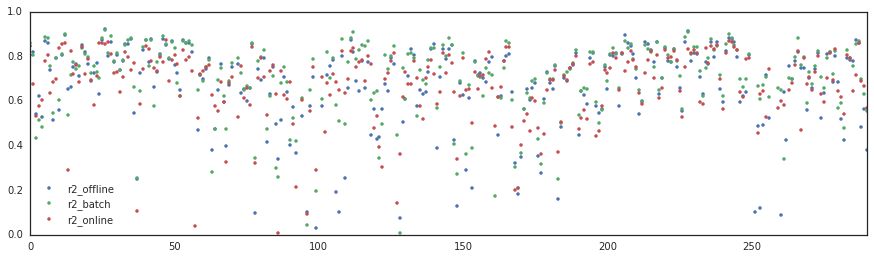

In [38]:
a=main_subset.groupby(main_subset.index.to_datetime().dayofyear, sort=False).apply(r2)

b = a[['r2_offline','r2_batch', 'r2_online']]

#a[['r2_offline','r2_batch']].plot( figsize=(15,4), marker='*')
b[b > 0].reset_index()[['r2_offline','r2_batch', 'r2_online']].plot( figsize=(15,4), marker='.', linestyle='')

Scatter plot for entire testing dataset with regression plot trend, showing that Batch is better. Unfortunatelly the trend is downword. Maybe try with different sensor.

In [39]:
a.shape

(291, 6)

C:\Python27\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)


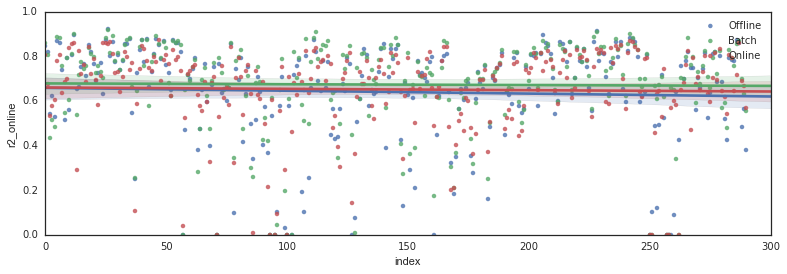

In [40]:
import seaborn as sns

sns.set_style("white")

a=main_subset.groupby(main_subset.index.to_datetime().dayofyear, sort=False).apply(r2)

#tmp = main_subset.loc['2014-04-17 00:00:00':'2015-02-01 23:59:00']
#a=tmp.groupby(tmp.index.to_datetime().dayofyear, sort=False).apply(r2)

b = a[['r2_offline','r2_batch', 'r2_online']]

#c = b.reset_index()[['r2_offline','r2_batch']]
c = b[b > 0].reset_index()[['r2_offline','r2_batch', 'r2_online']]
c = c.fillna(0)
c['index'] = c.index

plt.figure(figsize=(13,4))
#sns.pairplot(c, size=5, aspect=.8, kind="reg");
g = sns.regplot(y="r2_offline", x="index", data=c, label='Offline');
g.set(xlim=(0,300), ylim=(0,1))
sns.regplot(y="r2_batch", x="index", data=c, label='Batch');
sns.regplot(y="r2_online", x="index", data=c, label='Online');

plt.legend(loc='upper right')
plt.show()

In [41]:
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[0].get_xdata(),y=g.get_lines()[0].get_ydata())
print "Offline slope:", slope

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[1].get_xdata(),y=g.get_lines()[1].get_ydata())
print "Batch slope:", slope

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[2].get_xdata(),y=g.get_lines()[2].get_ydata())
print "Online slope:", slope

Offline slope: -0.000128687113617
Batch slope: -3.70384806799e-05
Online slope: -5.94614100887e-05


## MAPE analysis

In [42]:
import regression_metrics as additional_metrics

def mape(g):
    mape_lv = additional_metrics.mean_absolute_percentage_error( g['true'], g['last value'] )
    mape_pd = additional_metrics.mean_absolute_percentage_error( g['true'], g['previous day'] )
    mape_pw = additional_metrics.mean_absolute_percentage_error( g['true'], g['previous week'] )
    mape_offline = additional_metrics.mean_absolute_percentage_error( g['true'], g['offline'] )
    mape_batch = additional_metrics.mean_absolute_percentage_error( g['true'], g['batch'] )
    mape_online = additional_metrics.mean_absolute_percentage_error( g['true'], g['online'] )
    return pd.Series( dict(  mape_lv=mape_lv, mape_pd=mape_pd, mape_pw=mape_pw, mape_offline=mape_offline, mape_batch=mape_batch, mape_online=mape_online ) )

C:\Python27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  if __name__ == '__main__':


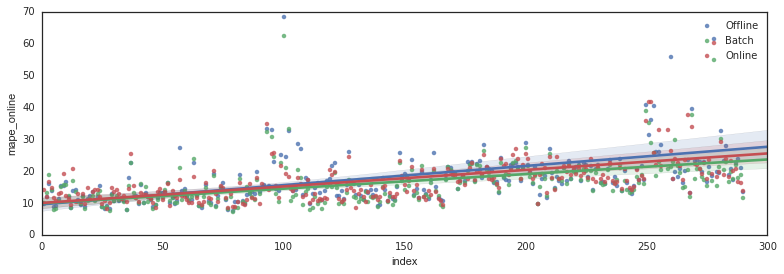

In [43]:
a=main_subset.groupby(main_subset.index.to_datetime().dayofyear, sort=False).apply(mape)

#tmp = main_subset.loc['2014-04-17 00:00:00':'2015-02-01 23:59:00']
#a=tmp.groupby(tmp.index.to_datetime().dayofyear, sort=False).apply(mape)

b = a[['mape_offline','mape_batch', 'mape_online']]

c = b[b > 0].reset_index()[['mape_offline','mape_batch', 'mape_online']]
c = c.fillna(0)
#c = b.reset_index()[['mape_offline','mape_batch']]
c['index'] = c.index

plt.figure(figsize=(13,4))
#sns.pairplot(c, size=5, aspect=.8, kind="reg");
g = sns.regplot(y="mape_offline", x="index", data=c, label='Offline');
g.set(xlim=(0,300), ylim=(0,70))
sns.regplot(y="mape_batch", x="index", data=c, label='Batch');
sns.regplot(y="mape_online", x="index", data=c, label='Online');

plt.legend(loc='upper right')
plt.show()

In [44]:
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[0].get_xdata(),y=g.get_lines()[0].get_ydata())
print "Offline slope:", slope

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[1].get_xdata(),y=g.get_lines()[1].get_ydata())
print "Batch slope:", slope

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[2].get_xdata(),y=g.get_lines()[2].get_ydata())
print "Online slope:", slope

Offline slope: 0.0601298757956
Batch slope: 0.0457804786711
Online slope: 0.0517230729355


In [25]:
main_subset.to_csv('./data/predictions_rf_id12041992.csv')

## Future work

- more horizons
- more sensors
- online approach